# Analisis Sentiment Data Twitter terhadap Tindakan Korupsi pada Kartu Prakerja di Indonesia dengan Algoritma Support Vektor Macine (SVM)

by KELOMPOK 4 :
IRHAN TAKDIR, ELISA ALTASANI, DEWI ARMAYASARI

Dataset diperoleh dari hasil crawling yang didapat dari : https://github.com/hadiyankp/indonlu/blob/2a1178a66c63f98ba0a72384b2ae57e6e940e6bc/dataset/dataset.csv

berdasarkan hastag/keyword kartu prakerja

# Data Extraction

In [7]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score

np.random.seed(500)

data = pd.read_csv('Dataset.csv')

print(data.shape)
data.head()

(4401, 2)


,Label,Tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


# Data Prepocessing

In [8]:
x = data['Tweet']

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

stopwords = StopWordRemoverFactory().get_stop_words() 
stemmer = StemmerFactory().create_stemmer()

import re 

def text_preprocess(text, stemmer, stopwords):
    x = text.str.replace(r'\W',' ')
    x = x.str.replace(r'\s+',' ')
    x = x.str.lower()
    x = x.apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split() if item not in stopwords]))
    return x

data['processed_text'] = text_preprocess(x, stemmer, stopwords)

In [9]:
data['processed_text']

0       soal jln jatibaru polisi tdk bs gertak gubernu...
1       sama cewe lho kayak harus lebih rasain lah sib...
2       kepingin gudeg mbarek bu hj amad foto google s...
3       jln jatibaru bagi wilayah tn abang atur wilaya...
4       sharing alam aja kemarin jam 18 00 batalin tik...
                              ...                        
4396    tahu kamu papa mejam mata tahan gejolak batin ...
4397    sulit tetap calon wapresnya jokowi pilpres 201...
4398    5 masa depan jelas lha iya gimana mau jelas co...
4399    username dulu beneran mahasiswa teknik ui nemb...
4400       allah engkau tahu rasa sakit hati sembuh allah
Name: processed_text, Length: 4401, dtype: object

In [10]:
import nltk
nltk.download()

wordfreq = {}
for sentence in data['processed_text']:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

import heapq
most_freq = heapq.nlargest(300, wordfreq, key=wordfreq.get)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [11]:
wordfreq = {token: freq for token, freq in sorted(wordfreq.items(), key=lambda item: item[1], reverse=True)} 
wordfreq

{'username': 1794,
 'yg': 1681,
 'aku': 1301,
 'sama': 906,
 'jadi': 774,
 'orang': 736,
 'ga': 730,
 'aja': 637,
 'url': 622,
 'mau': 609,
 'kalo': 581,
 'gue': 570,
 'apa': 550,
 'cinta': 543,
 'sayang': 526,
 'kamu': 520,
 'buat': 517,
 'udah': 483,
 'gak': 474,
 'takut': 449,
 'rasa': 346,
 'banget': 345,
 'nya': 344,
 'sih': 341,
 'lebih': 335,
 'banyak': 333,
 'semua': 312,
 'baik': 309,
 'selalu': 301,
 'tak': 292,
 'hari': 288,
 'tau': 280,
 'suka': 276,
 'gitu': 275,
 'kalau': 270,
 'gw': 268,
 'salah': 265,
 'anak': 262,
 'tp': 260,
 'terus': 260,
 'hati': 259,
 'ku': 259,
 'sendiri': 258,
 'bukan': 258,
 'pas': 258,
 'kan': 248,
 'pernah': 247,
 'baru': 243,
 'diri': 238,
 'bikin': 237,
 'satu': 233,
 'punya': 232,
 'jangan': 231,
 'cuma': 229,
 'dulu': 229,
 'kasih': 227,
 'kata': 222,
 'jalan': 222,
 'gua': 214,
 'hidup': 209,
 'malah': 203,
 'bgt': 201,
 'si': 197,
 'sampe': 196,
 'moga': 194,
 'nyata': 192,
 'lah': 190,
 'makin': 189,
 'bilang': 188,
 'lama': 188,
 'akhi

# Feature Bag of Word (BOW)

In [12]:
import numpy as np  
import random  
import string

sentence_vectors = []
for sentence in data['processed_text']:
    sentence_tokens = nltk.word_tokenize(sentence)
    sent_vec = []
    for token in most_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

sentence_vectors = np.asarray(sentence_vectors)
print(sentence_vectors)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Feature TF-IDF

In [13]:
word_idf_values = {}
for token in most_freq:
    doc_containing_word = 0
    for document in data['processed_text']:
        if token in nltk.word_tokenize(document):
            doc_containing_word += 1
    word_idf_values[token] = np.log(len(x)/(1 + doc_containing_word))


word_tf_values = {}
for token in most_freq:
    sent_tf_vector = []
    for document in data['processed_text']:
        doc_freq = 0
        for word in nltk.word_tokenize(document):
            if token == word:
                  doc_freq += 1
        word_tf = doc_freq/len(nltk.word_tokenize(document))
        sent_tf_vector.append(word_tf)
    word_tf_values[token] = sent_tf_vector
    
tfidf_values = []
for token in word_tf_values.keys():
    tfidf_sentences = []
    for tf_sentence in word_tf_values[token]:
        tf_idf_score = tf_sentence * word_idf_values[token]
        tfidf_sentences.append(tf_idf_score)
    tfidf_values.append(tfidf_sentences)

tf_idf_model = np.asarray(tfidf_values)
tf_idf_model = np.transpose(tf_idf_model)

print(tf_idf_model)

[[0.09313375 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.04977838 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Labelling Target

In [33]:
from sklearn.preprocessing import LabelEncoder
le_label = LabelEncoder()

data['Label'] = le_label.fit_transform(data['Label'])
y = data['Label']

y

0       0
1       0
2       2
3       0
4       2
       ..
4396    3
4397    1
4398    0
4399    2
4400    4
Name: Label, Length: 4401, dtype: int64

# Data Modelling

In [41]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tf_idf_model, y, test_size=(0.2))

SVM = svm.SVC(C=9.5, kernel='linear', degree=5, gamma='auto')
SVM.fit(x_train, y_train)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(x_test)

# menghitung akurasi
accuracy = accuracy_score(predictions_SVM, y_test)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 61.07%


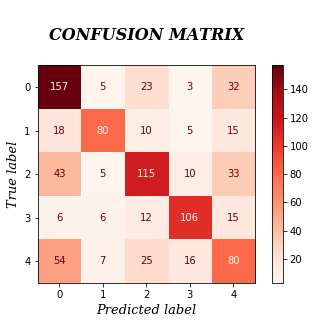

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix

# plot confusion matriks
plot_confusion_matrix(SVM, x_test, y_test,
                    cmap=plt.cm.Reds,
                    values_format='.4g')

plt.title('\nCONFUSION MATRIX\n', size=16, weight='bold', style='oblique', family='serif')
plt.ylabel('True label', size=13, weight='medium', style='oblique', family='serif')
plt.xlabel('Predicted label', size=13, weight='medium', style='oblique', family='serif')
plt.show()

In [45]:
y_pred = SVM.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.71      0.63       220
           1       0.78      0.62      0.69       128
           2       0.62      0.56      0.59       206
           3       0.76      0.73      0.74       145
           4       0.46      0.44      0.45       182

    accuracy                           0.61       881
   macro avg       0.64      0.61      0.62       881
weighted avg       0.62      0.61      0.61       881



# Data Cleaning

In [39]:
import re

x = data['Tweet']

# membersihkan tweets dengan menghapus username, RT, link, dan karakter yang tidak dibutuhkan
for i in range(len(x)):
    x[i] = re.sub(r'@[\w:]+', '', x[i])
    x[i] = re.sub(r'RT[\s]+', '', x[i])
    x[i] = re.sub(r'https?:\/\/\S+', '', x[i])
    x[i] = re.sub(r'[\n\t#:]+','', x[i])

In [40]:
# setelah data dibersihkan bisa saja ada baris yang hanya berisi string kosong,
# sehingga kita harus mensortir dan memilih baris yang berisi kalimat
x = x[x != '']
x

0       Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...
1       Sesama cewe lho (kayaknya), harusnya bisa lebi...
2       Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3       Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...
4       Sharing pengalaman aja, kemarin jam 18.00 bata...
                              ...                        
4396    Tahukah kamu, bahwa saat itu papa memejamkan m...
4397    Sulitnya menetapkan Calon Wapresnya Jokowi di ...
4398    5. masa depannya nggak jelas. lha iya, gimana ...
4399    [USERNAME] dulu beneran ada mahasiswa Teknik U...
4400    Ya Allah, hanya Engkau yang mengetahui rasa sa...
Name: Tweet, Length: 4401, dtype: object

# Analyze The Data

In [5]:
from textblob import TextBlob 

# fungsi untuk menghitung nilai subjectivity
def subjectivity(tweet):
    return TextBlob(tweet).translate(from_lang='id', to='en').sentiment.subjectivity

# fungsi untuk menghitung nilai polarity
def polarity(tweet):
    return TextBlob(tweet).translate(from_lang='id', to='en').sentiment.polarity

# membuat kolom baru yang berisikan nilai subjectivity dan polarity
data['Subjectivity'] = x.apply(subjectivity)
data['Polarity'] = x.apply(polarity)
data['Tweet'] = x
data

,Tweet,Subjectivity,Polarity
0,Sebanyak 89 persen konten pelatihan di program...,0.466667,0.333333
1,"Kartu Prakerja Dihentikan, DPR Dari Awal ini k...",0.000000,0.100000
2,Kartu Prakerja yang digadang-gadang sebagai pr...,0.000000,0.000000
3,Sebanyak 89 persen konten pelatihan di program...,0.466667,0.333333
4,Kartu Prakerja yang digadang-gadang sebagai pr...,0.000000,0.000000
...,...,...,...
2347,Ketua Komisi Pemberantasan Korupsi Firli Bahur...,0.375000,-0.125000
2348,Ketua Komisi Pemberantasan Korupsi Firli Bahur...,0.375000,-0.125000
2349,Ketua Komisi Pemberantasan Korupsi Firli Bahur...,0.375000,-0.125000
2350,Ironis yah... di satu pihak ada yg sangat berh...,0.393750,0.068750


# Word Cloud Visualization

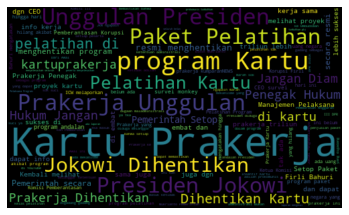

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# membuat visualisasi dengan word cloud
words = ' '.join([word for word in x])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(words)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
# membuat fungsi untuk mengkategorikan ploarity
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Netral'
    else:
        return 'Positive'

# membuat kolom baru yang menampilkan hasil pengkategorian polarity
data['Analysis'] = data['Polarity'].apply(analysis)
data

,Tweet,Subjectivity,Polarity,Analysis
0,Sebanyak 89 persen konten pelatihan di program...,0.466667,0.333333,Positive
1,"Kartu Prakerja Dihentikan, DPR Dari Awal ini k...",0.000000,0.100000,Positive
2,Kartu Prakerja yang digadang-gadang sebagai pr...,0.000000,0.000000,Netral
3,Sebanyak 89 persen konten pelatihan di program...,0.466667,0.333333,Positive
4,Kartu Prakerja yang digadang-gadang sebagai pr...,0.000000,0.000000,Netral
...,...,...,...,...
2347,Ketua Komisi Pemberantasan Korupsi Firli Bahur...,0.375000,-0.125000,Negative
2348,Ketua Komisi Pemberantasan Korupsi Firli Bahur...,0.375000,-0.125000,Negative
2349,Ketua Komisi Pemberantasan Korupsi Firli Bahur...,0.375000,-0.125000,Negative
2350,Ironis yah... di satu pihak ada yg sangat berh...,0.393750,0.068750,Positive


# Show Positive Sentiment

In [8]:
# menampilkan tweets bernilai positif
no = 1
sortedData = data.sort_values(by=['Polarity'])
for i in range(sortedData.shape[0]):
    if (sortedData['Analysis'][i] == 'Positive'):
        print(str(no) + ') ' + sortedData['Tweet'][i], '\n')
        no += 1

1) Sebanyak 89 persen konten pelatihan di program Kartu Prakerja tersedia gratis di YouTube.KoranTempo BolongKartuPrakerja… 

2) Kartu Prakerja Dihentikan, DPR Dari Awal ini kan Pemborosan Anggaran 

3) Sebanyak 89 persen konten pelatihan di program Kartu Prakerja tersedia gratis di YouTube.KoranTempo BolongKartuPrakerja… 

4) Sebanyak 89 persen konten pelatihan di program Kartu Prakerja tersedia gratis di YouTube.KoranTempo BolongKartuPrakerja… 

5) Sebanyak 89 persen konten pelatihan di program Kartu Prakerja tersedia gratis di YouTube.KoranTempo BolongKartuPrakerja… 

6) Sebanyak 89 persen konten pelatihan di program Kartu Prakerja tersedia gratis di YouTube.KoranTempo BolongKartuPrakerja… 

7) Sebanyak 89 persen konten pelatihan di program Kartu Prakerja tersedia gratis di YouTube.KoranTempo BolongKartuPrakerja… 

8) siapa mau beli? 

9) Lantas, mengapa kontroversi-kontroversi tersebut bisa terjadi? Selengkapnya di sini  TopNews  

10) Pendaftaran Kartu Prakerja gelombang 4 dalam w

177) Tadinya respect sm  tapi gegara kartu prakerja jd rada ilfeel 😐 

178) Kartu Prakerja Unggulan Presiden Jokowi Dihentikan 

179)  Boro boro jadi kuli anak cucu kita yg ada kulinya juga pasti aseng kita mah cukup kartu prakerja. 🤣🤣 

180) Kartu Prakerja Unggulan Presiden Jokowi Dihentikan 

181) Kartu Prakerja Unggulan Presiden Jokowi Dihentikan 

182) Kartu Prakerja Unggulan Presiden Jokowi Dihentikan 

183) Kartu Prakerja Unggulan Presiden Jokowi Dihentikan 

184) Kartu Prakerja Unggulan Presiden Jokowi Dihentikan 

185) Kartu Prakerja Unggulan Presiden Jokowi Dihentikan 

186) Kartu Prakerja Unggulan Presiden Jokowi Dihentikan 

187) Kembali melihat proyek kartu prakerja. 5 triliun lebih sukses di embat dan dapat info kerja sama juga dgn CEO survei monkey… 

188) Kembali melihat proyek kartu prakerja. 5 triliun lebih sukses di embat dan dapat info kerja sama juga dgn CEO survei monkey… 

189) Kartu Prakerja Unggulan Presiden Jokowi Dihentikan 

190) Sebuah kebetulan yg hebat. Pe

TypeError: can only concatenate str (not "float") to str

# Show Negative Sentiment

In [9]:
# menampilkan tweets bernilai negative
no = 1
sortedData = data.sort_values(by=['Polarity'], ascending=False)
for i in range(sortedData.shape[0]):
    if (sortedData['Analysis'][i] == 'Negative'):
        print(str(no) + ') ' + sortedData['Tweet'][i], '\n')
        no += 1

1) Kartu Prakerja Dihentikan, Komisi IX DPR Netty Prasetiyani Aher Dari Awal ini kan Pemborosan Anggaran 

2) inilah akibat otak2 perencana pembangunan di lingkar istana dikibuli habis2an oleh stafsus milenial kapitalispemerintah me… 

3) Penundaan pendaftaran Kartu Prakerja gelombang 4 yg hingga saat ini belum dibuka, disebabkan pemerintah yg masih me…  

4) Kartu Prakerja Dihentikan, Komisi IX DPR Netty Prasetiyani Aher Dari Awal ini kan Pemborosan Anggaran 

5) Kartu Prakerja Dihentikan, Komisi IX DPR Netty Prasetiyani Aher Dari Awal ini kan Pemborosan Anggaran 

6) Kartu Prakerja Dihentikan, Komisi IX DPR Netty Prasetiyani Aher Dari Awal ini kan Pemborosan Anggaran 

7) Kartu Prakerja Dihentikan, Komisi IX DPR Netty Prasetiyani Aher Dari Awal ini kan Pemborosan Anggaran 

8) Kartu Prakerja Unggulan Presiden Jokowi Dihentikan.Program yang tidak bermanfaat.  Padahal Dana Anggarannya mencapai 5,6 T… 

9) Ngenes nasib kartu Prakerja. Program Goblok macam begini cuma buang-buang duit ne

234) Kita bingung mau ngadu kemana pa, jangan begini lah pemerintah sama rakyat..Kita ngadu lewat email dibales sama robot, n… 

235)  mohon maaf pak, sekedar mau tanya. Kenapa njih kok dana kartuprakerja Untuk pencairan yg ke 2 susah…  

236) Kita bingung mau ngadu kemana pa, jangan begini lah pemerintah sama rakyat..Kita ngadu lewat email dibales sama robot, n… 

237) Kita bingung mau ngadu kemana pa, jangan begini lah pemerintah sama rakyat..Kita ngadu lewat email dibales sama r…  

238) KartuPrakerja kenapa Insentif tulisanya gagal dan dana pun belum masuk.kalau kasus awal pada ewallet ovo itu statu…  

239) Kegiatan PSBB ini lalu ditutup dengan penyerahan plakat secara simbolis oleh Kepala Subdit Data dan Dukungan Teknis…  

240) Manteman, bagi yg kemarin masih bingung mengapa insentif kartu prakerja blom juga cair bisa menyimak penjelasan dari Bu… 

241) Manteman, bagi yg kemarin masih bingung mengapa insentif kartu prakerja blom juga cair bisa menyimak penjelasan dari Bu… 

242)

# Visualization Data

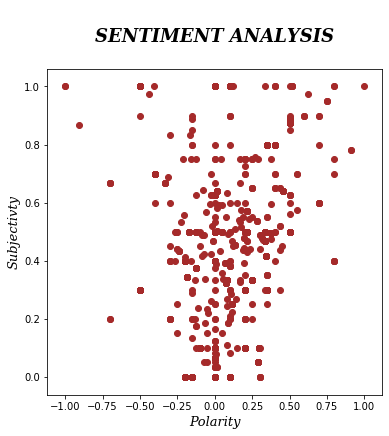

In [10]:
# membuat scatter plot penyebaran data 
plt.figure(figsize=(6,6))
for i in range(data.shape[0]):
    plt.scatter(data['Polarity'][i], data['Subjectivity'][i], color='brown')

plt.title('\nSENTIMENT ANALYSIS\n', size=18, weight='bold', style='oblique', family='serif')
plt.xlabel('Polarity', size=13, weight='medium', style='oblique', family='serif')
plt.ylabel('Subjectivty', size=13, weight='medium', style='oblique', family='serif')
plt.show()

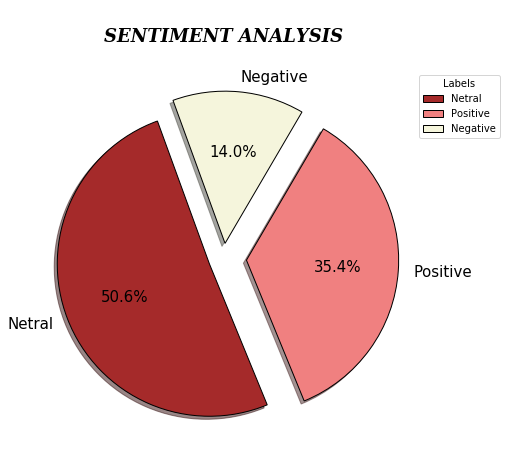

In [11]:
# membuat presentase jumlah tweets  
colors = ('brown', 'lightcoral', 'beige')
explode = (0.1, 0.15, 0.1) 
wp = {'linewidth' : 1, 'edgecolor' : "black"}

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect='equal')) 

data['Analysis'].value_counts().plot(kind='pie', autopct='%1.1f%%', explode=explode, 
                                colors=colors, fontsize=15, shadow=True, startangle=110, 
                                wedgeprops=wp, textprops=dict(size=12))


ax.legend(title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1.8)) 

ax.set_title('\nSENTIMENT ANALYSIS\n', size=18, weight='bold', style='oblique', family='serif')
ax.set_ylabel('')

plt.show()

# SEKIAN